# Air Pollution by Politics

## Imports & Installs

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import os
import json
import pandas as pd
import time
from refs import state_abbreviation_dict, environmental_terms

! pip install xlrd
! pip install openpyxl

## Loads

In [2]:
presidential_data = pd.read_csv('data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('data/general_state_data/state_sizes.csv')

## Analysis

### Global Functions

In [3]:
def plot_top_bottom_emissions(df):
    df = df[~df['State'].str.contains("Total", case=False, na=False)]
    year_columns = [col for col in df.columns if isinstance(col, int)]
    top_states = df.set_index('State')[year_columns].mean(axis=1).nlargest(10)
    bottom_states = df.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

    plt.figure(figsize=(12, 6))
    top_states.plot(kind='bar', color='red', alpha=0.7)
    plt.title("Top 10 States with Highest Average Emissions")
    plt.xlabel("State")
    plt.ylabel("Average Emissions")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    bottom_states.plot(kind='bar', color='green', alpha=0.7)
    plt.title("Top 10 States with Lowest Average Emissions")
    plt.xlabel("State")
    plt.ylabel("Average Emissions")
    plt.xticks(rotation=45)
    plt.show()


def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']

    df_summary['year'] = year

    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import argrelextrema

def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10).index
    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]
            local_max_idx = argrelextrema(emissions, np.greater)[0]
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],
                "max": [(years[i], emissions[i]) for i in local_max_idx]
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', label="Min" if state == list(data.columns)[0] else "")
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['final_score_avg'].values
                if len(score) > 0:
                    plt.text(x, y, f"{score[0]:.2f}", fontsize=9, verticalalignment='bottom')

            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', label="Max" if state == list(data.columns)[0] else "")
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['final_score_avg'].values
                if len(score) > 0:
                    plt.text(x, y, f"{score[0]:.2f}", fontsize=9, verticalalignment='top')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 10 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 10 States with Lowest Emissions Over Time", political_scores_data)

def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def extract_state_name(base_directory):
    return os.path.basename(base_directory)

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

### Election Analysis

In [4]:
final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year

,state,year,final_score_avg
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

In [5]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


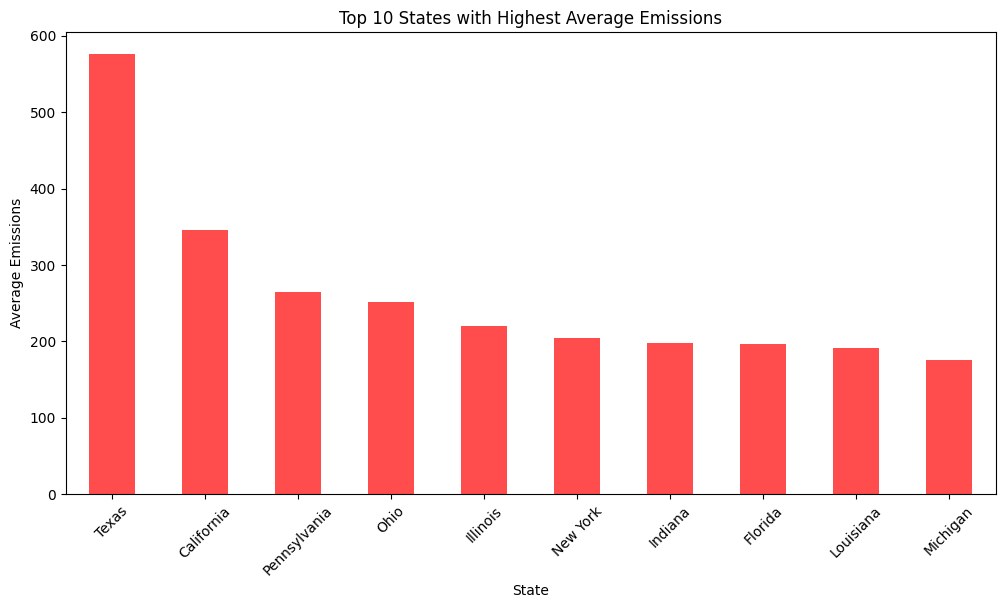

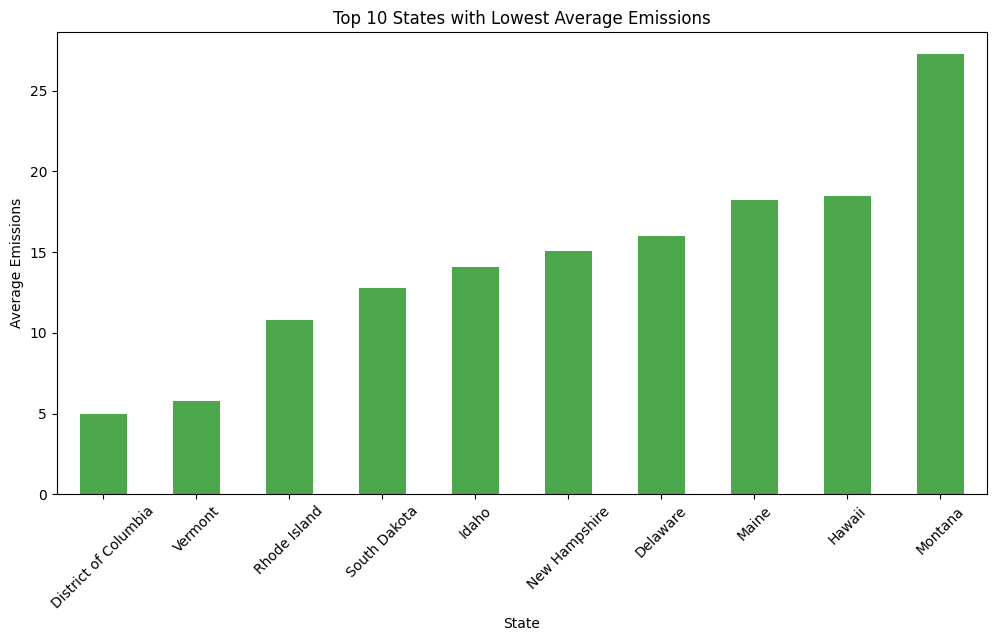

In [6]:
plot_top_bottom_emissions(state_emissions_data)

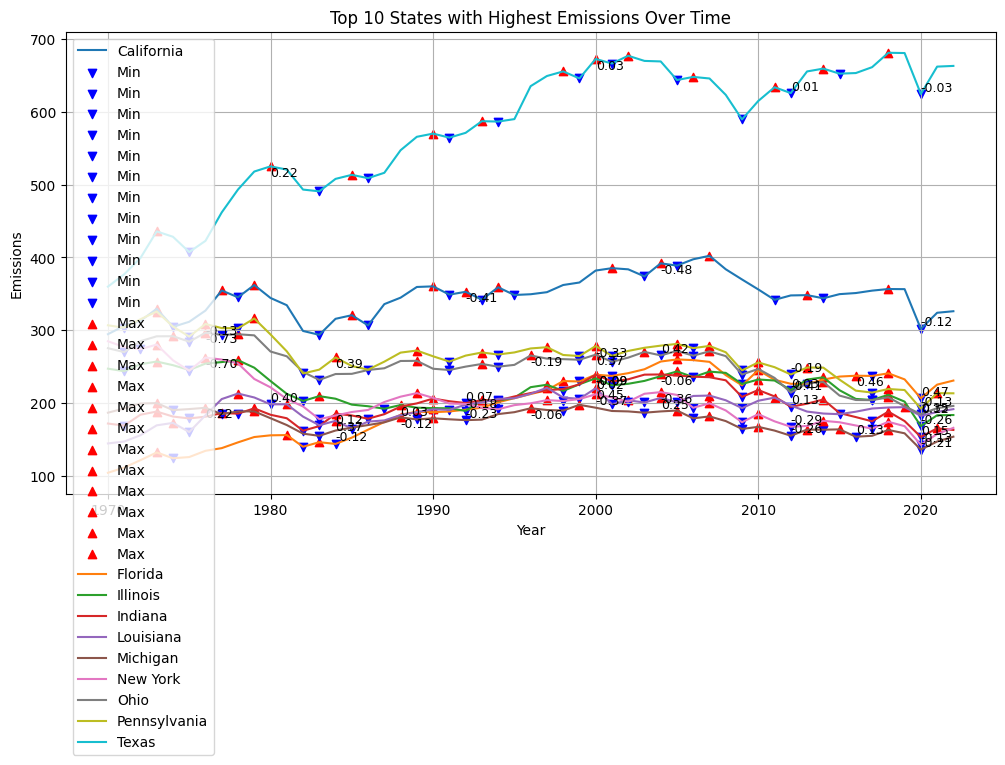

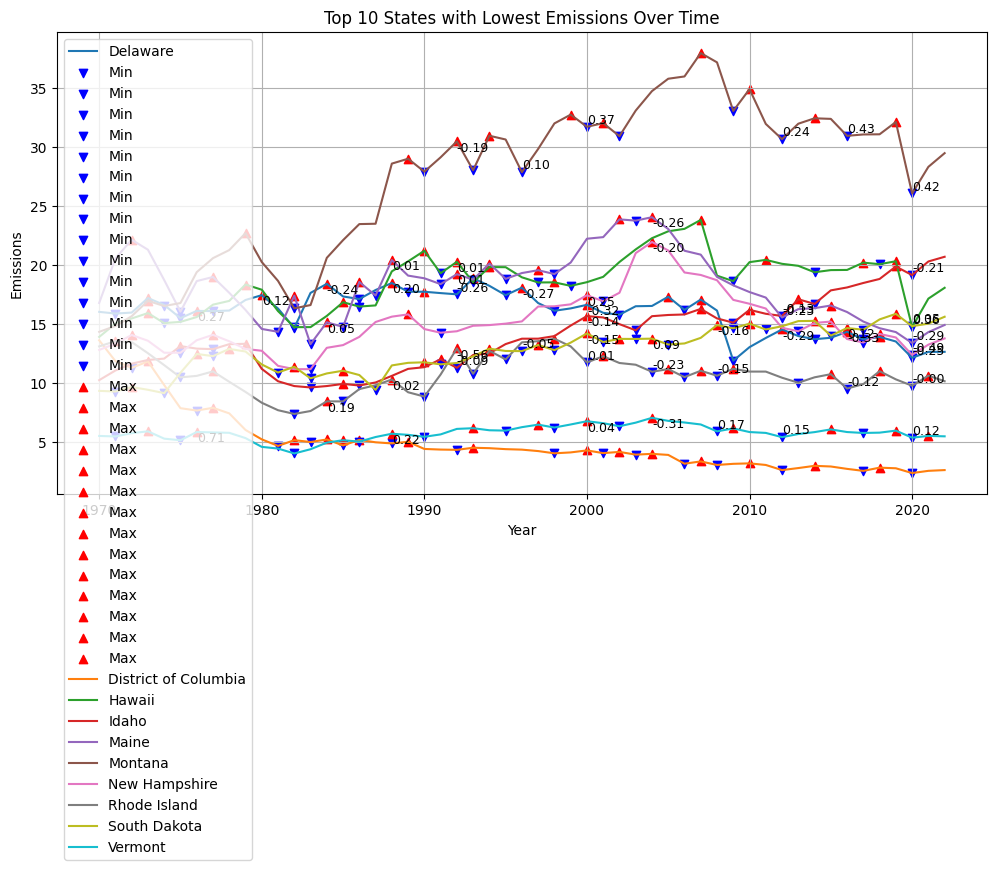

In [7]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

In [8]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,final_score_avg
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

In [9]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

In [10]:
election_scores_df = pd.read_csv('data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


In [11]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,final_score_avg
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


In [12]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns
imputer = KNNImputer(n_neighbors=5)
final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])
final_df_imputed

,Policy Scores,state,year,emissions,population,size,final_score_avg
0,27.000440,AL,1980.0,107.172609,3900368.0,52420.0,0.707140
1,42.097413,AL,1984.0,95.389801,3951820.0,52420.0,0.365180
2,42.097413,AL,1988.0,105.221571,4023844.0,52420.0,0.121370
3,27.183586,AL,1992.0,120.975301,4139269.0,52420.0,0.225649
4,17.721870,AL,1996.0,137.217372,4290403.0,52420.0,0.015759
...,...,...,...,...,...,...,...
578,7.146112,WY,2004.0,64.383683,509106.0,97813.0,-0.206691
579,3.146390,WY,2008.0,67.222540,546043.0,97813.0,-0.211750
580,14.832834,WY,2012.0,66.647098,576656.0,97813.0,-0.260097
581,12.360478,WY,2016.0,61.035090,585243.0,97813.0,-0.280461


#### Normalize Data

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

unnorm_final_df_imputed = final_df_imputed.copy()
scaler = StandardScaler()
columns_to_normalize = [col for col in final_df_imputed.columns if col not in ["state", "year", 'emissions']]
final_df_imputed[columns_to_normalize] = scaler.fit_transform(final_df_imputed[columns_to_normalize])
final_df_imputed

,Policy Scores,state,year,emissions,population,size,final_score_avg
0,0.352368,AL,1980.0,107.172609,-0.267936,-0.242253,2.655226
1,1.003895,AL,1984.0,95.389801,-0.259541,-0.242253,1.423585
2,1.003895,AL,1988.0,105.221571,-0.247790,-0.242253,0.545455
3,0.360271,AL,1992.0,120.975301,-0.228956,-0.242253,0.921038
4,-0.048060,AL,1996.0,137.217372,-0.204297,-0.242253,0.165075
...,...,...,...,...,...,...,...
578,-0.504469,WY,2004.0,64.383683,-0.821263,0.237924,-0.636125
579,-0.677082,WY,2008.0,67.222540,-0.815236,0.237924,-0.654347
580,-0.172740,WY,2012.0,66.647098,-0.810241,0.237924,-0.828477
581,-0.279437,WY,2016.0,61.035090,-0.808840,0.237924,-0.901824


In [14]:
final_df_imputed.columns

Index(['Policy Scores', 'state', 'year', 'emissions', 'population', 'size',
       'final_score_avg'],
      dtype='object')

In [16]:
final_df_imputed = pd.get_dummies(final_df_imputed, columns=['state'])

final_df_imputed

,Policy Scores,year,emissions,population,size,final_score_avg,state_AK,state_AL,state_AR,state_AZ,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.352368,1980.0,107.172609,-0.267936,-0.242253,2.655226,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.003895,1984.0,95.389801,-0.259541,-0.242253,1.423585,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.003895,1988.0,105.221571,-0.247790,-0.242253,0.545455,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.360271,1992.0,120.975301,-0.228956,-0.242253,0.921038,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.048060,1996.0,137.217372,-0.204297,-0.242253,0.165075,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-0.504469,2004.0,64.383683,-0.821263,0.237924,-0.636125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
579,-0.677082,2008.0,67.222540,-0.815236,0.237924,-0.654347,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
580,-0.172740,2012.0,66.647098,-0.810241,0.237924,-0.828477,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
581,-0.279437,2016.0,61.035090,-0.808840,0.237924,-0.901824,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
state_columns = final_df_imputed.columns[6:]
state_columns

Index(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY'],
      dtype='object')

## Final Analysis

current setup predicts present. for future iterations train on 10 year gaps WITHIN the data. For 10 year future use time series model.

### Current Predictions

In [21]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Selecting features and target
columns_to_select = ['Policy Scores', 'population', 'size', 'final_score_avg'] + list(state_columns)
X = final_df_imputed[columns_to_select]
y = final_df_imputed['emissions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start the timer
start_time = time.time()

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

end_time = time.time()

mse = mean_squared_error(y_test, y_pred)
elapsed_time = end_time - start_time

print(f'Mean Squared Error: {mse}')
print(f'Time taken: {elapsed_time} seconds')

Mean Squared Error: 330.1479551915618
Time taken: 0.17955899238586426 seconds


Mean Squared Error: 347.74363414912074
Time taken: 0.06531095504760742 seconds


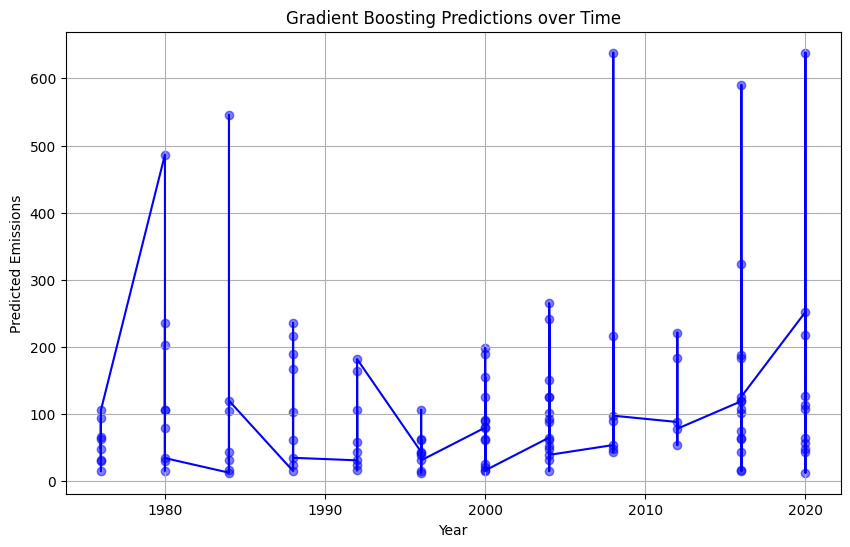

In [22]:
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Selecting features and target
columns_to_select = ['Policy Scores', 'population', 'size', 'final_score_avg'] + list(state_columns)
X = final_df_imputed[columns_to_select]
y = final_df_imputed['emissions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start the timer
start_time = time.time()

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred = gb_model.predict(X_test)

# End the timer
end_time = time.time()

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
elapsed_time = end_time - start_time

# Print time taken and MSE
print(f'Mean Squared Error: {mse}')
print(f'Time taken: {elapsed_time} seconds')

# Add predictions to the test set
X_test['predictions'] = y_pred
X_test['year'] = final_df_imputed.loc[X_test.index, 'year']

# Sort by year for the plot
X_test = X_test.sort_values(by='year')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test['year'], X_test['predictions'], label='Predictions', color='blue')
plt.scatter(X_test['year'], X_test['predictions'], color='blue', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Predicted Emissions')
plt.title('Gradient Boosting Predictions over Time')
plt.grid(True)
plt.show()

In [32]:
final_df_imputed.to_csv('/Users/ayalyakobe/Desktop/AirPollutionByPolitics/data.csv')

In [37]:
final_df_imputed

,Policy Scores,emissions,population,size,final_score_avg,state_AK,state_AL,state_AR,state_AZ,state_CA,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
year,,,,,,,,,,,,,,,,,,,,,
1980.0,0.352368,107.172609,-0.267936,-0.242253,2.655226,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984.0,1.003895,95.389801,-0.259541,-0.242253,1.423585,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1988.0,1.003895,105.221571,-0.247790,-0.242253,0.545455,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992.0,0.360271,120.975301,-0.228956,-0.242253,0.921038,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996.0,-0.048060,137.217372,-0.204297,-0.242253,0.165075,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004.0,-0.504469,64.383683,-0.821263,0.237924,-0.636125,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2008.0,-0.677082,67.222540,-0.815236,0.237924,-0.654347,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2012.0,-0.172740,66.647098,-0.810241,0.237924,-0.828477,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Future Predictions

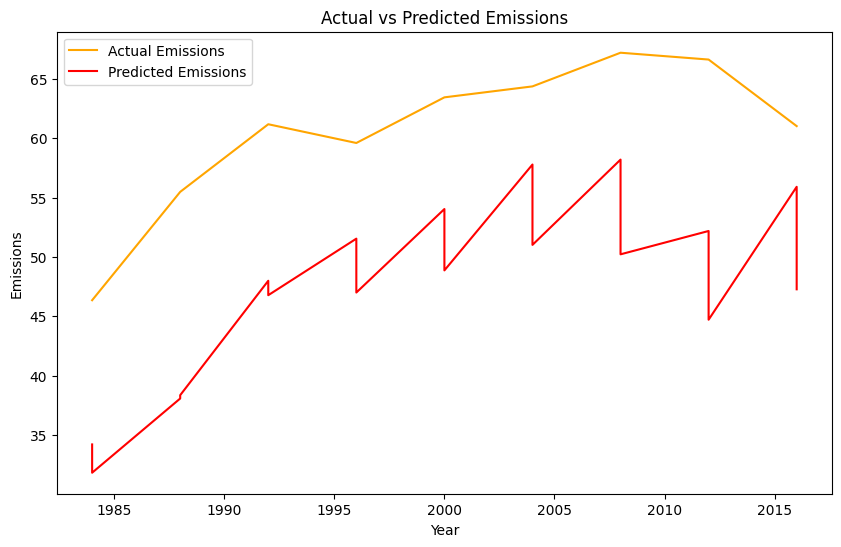

Mean Squared Error: 187.9081923541504
R^2 Score: -4.843988621361275


,Year,Actual Emissions,Predicted Emissions
0,1984,46.352490,34.194597
1,1984,46.352490,31.808720
2,1984,46.352490,31.808720
3,1988,55.489700,38.066789
4,1988,55.489700,38.066789
5,1988,55.489700,38.347392
6,1988,55.489700,38.347392
7,1992,61.192180,47.994866
8,1992,61.192180,47.994866
9,1992,61.192180,46.777821


In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame (final_df_imputed)
data = final_df_imputed

# Convert 'year' index to integers to avoid float64 issues
data.index = data.index.astype(int)

# Function to split the data into 10-year intervals
def split_into_10_year_intervals(df):
    intervals = []
    years = df.index.unique()  # Get the unique years from the index
    for start_year in range(years.min(), years.max() - 9):  # Use years.min() and years.max()
        end_year = start_year + 9
        interval = df[(df.index >= start_year) & (df.index <= end_year)]
        intervals.append(interval)
    return intervals

# Split the data into 10-year intervals
intervals = split_into_10_year_intervals(data)

# Prepare the data and train the model for each interval
predictions = []
actual_emissions = []

for interval in intervals:
    # Split the data into features and target variable
    X = interval.drop(columns=['emissions'])
    y = interval['emissions']

    # Split the interval into training and testing sets (using the last year for testing)
    train_data = X.iloc[:-1]
    test_data = X.iloc[-1:]

    train_target = y.iloc[:-1]
    test_target = y.iloc[-1:]

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_data, train_target)

    # Predict emissions for the test year
    predictions.append(model.predict(test_data)[0])
    actual_emissions.append(test_target.values[0])

# Calculate the model's performance
mse = mean_squared_error(actual_emissions, predictions)
r2 = r2_score(actual_emissions, predictions)

# Display the results
pred_df = pd.DataFrame({
    'Year': [intervals[i].index[-1] for i in range(len(intervals))],  # Correctly extract the last year of each interval
    'Actual Emissions': actual_emissions,
    'Predicted Emissions': predictions
})

# Plot the actual vs predicted emissions
plt.figure(figsize=(10, 6))
plt.plot(pred_df['Year'], pred_df['Actual Emissions'], label='Actual Emissions', color='orange')
plt.plot(pred_df['Year'], pred_df['Predicted Emissions'], label='Predicted Emissions', color='red')
plt.legend()
plt.title('Actual vs Predicted Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.show()

# Print model performance
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Show the predictions
pred_df


### Unsupervised Analysis

In [ ]:
final_df_imputed['political_party'] = final_df_imputed['final_score_avg'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_imputed

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming final_df_imputed is your DataFrame

# 1. Assign Political Party Labels
final_df_imputed['political_party'] = final_df_imputed['final_score_avg'].apply(lambda x: 'D' if x > 0 else 'R')

# 2. Select Features for PCA
features = ['Policy Scores', 'population', 'size', 'final_score_avg']
X = final_df_imputed[features]

# 3. Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# 5. Create a DataFrame with PCA results and political party
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['political_party'] = final_df_imputed['political_party']

# 6. Plotting the Results
plt.figure(figsize=(10, 6))

# Scatter plot colored by political party
colors = {'D': 'blue', 'R': 'red'}
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['political_party'].apply(lambda x: colors[x]), label=pca_df['political_party'], alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Political Parties')
plt.grid(True)
plt.legend(['Democrat', 'Republican'])
plt.show()
